# Using PCA For Feature Extraction

This notebook demonstrates how Principal Component Analysis (PCA) can be used to:
1. Extract meaningful features from high-dimensional image data
2. Visualize high-dimensional data in 2D
3. Generate new images using PCA components

## Import Libraries

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from IPython import display
from matplotlib import offsetbox
import numpy as np
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


## Load the Dataset

In [2]:
# load the data, and it may take a while
fasion_mnist=fetch_openml(name="Fashion-MNIST")

I had trouble with this cell depending on my version of sklearn

In [3]:
try:
    data=fasion_mnist.data.values
except:
    data=fasion_mnist.data
#data should be numpy array    
images=data.reshape(-1,28,28)
target=fasion_mnist.target.astype('int64')

### Understanding Data Dimensions

These cells help me get a clearer picture about the data I am working with.

In [4]:
#a row in data is an image (28x28 reshaped into a vector of 784 elements)
data.shape

(70000, 784)

In [5]:
# images[0] is the first image (28x28)
images.shape

(70000, 28, 28)

In [6]:
#an element in target is the class label of the corresponding image in data
target.shape

(70000,)

In [7]:
[target.min(), target.max()]

[0, 9]

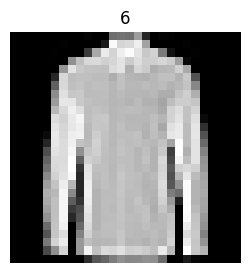

<Figure size 640x480 with 0 Axes>

In [8]:
# show some of the images

fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, target.shape[0], 1000):
    x=data[n,:]
    x=x.reshape(28,28) # reshape a vector to an image
    ax.imshow(x, cmap='gray')    
    ax.axis('off')
    ax.set_title(target[n])
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.1)  

We define a helper function that will plot our PCA-transformed data:
- Shows data points in 2D space
- Optionally displays thumbnail images at data points
- Helps visualize how PCA organizes the images in 2D space

In [9]:
# Function to plot the image components in 2D
def plot_components(data, model, images, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

## Applying PCA for Dimensionality Reduction
 
We'll use Incremental PCA which is more memory-efficient for large datasets:
1. Reduce dimensions from 784 to 2 for visualization
2. Process data in batches to manage memory usage
3. Transform our data into the new 2D space

In [10]:
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=100)
transformed_data = ipca.fit_transform(data)

### Visualizing the PCA Results
 
Let's create several visualizations to understand how PCA has organized our data:
1. All classes colored by their labels
2. Single class visualization
3. Thumbnail images showing actual fashion items in 2D space

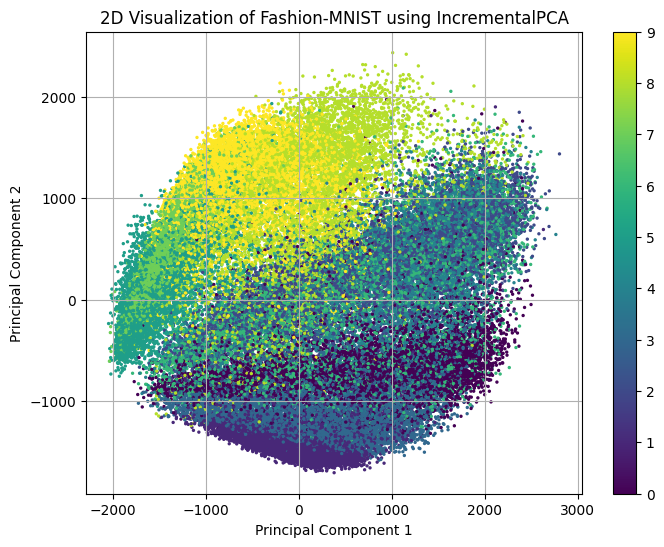

In [11]:
# Create a scatter plot of the 2D projection
plt.figure(figsize=(8, 6))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=target, cmap='viridis', s=2)
plt.colorbar()  # Optional: show color bar to indicate different labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Fashion-MNIST using IncrementalPCA')
plt.grid(True)
plt.show()



### Visualizing Single Class Distribution
 
Let's focus on how a single class (label 0) is distributed in our 2D space.
This helps us understand if similar items cluster together.

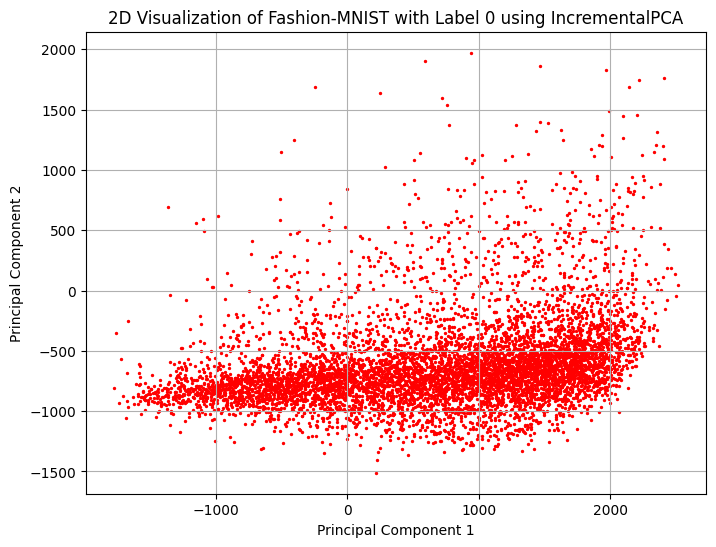

In [12]:
#show only the data points/images with class label=0 (i.e. target is 0) in 2D
label_0 = transformed_data[target == 0]

plt.figure(figsize=(8, 6))
plt.scatter(label_0[:, 0], label_0[:, 1], c='red', s=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Fashion-MNIST with Label 0 using IncrementalPCA')
plt.grid(True)
plt.show()

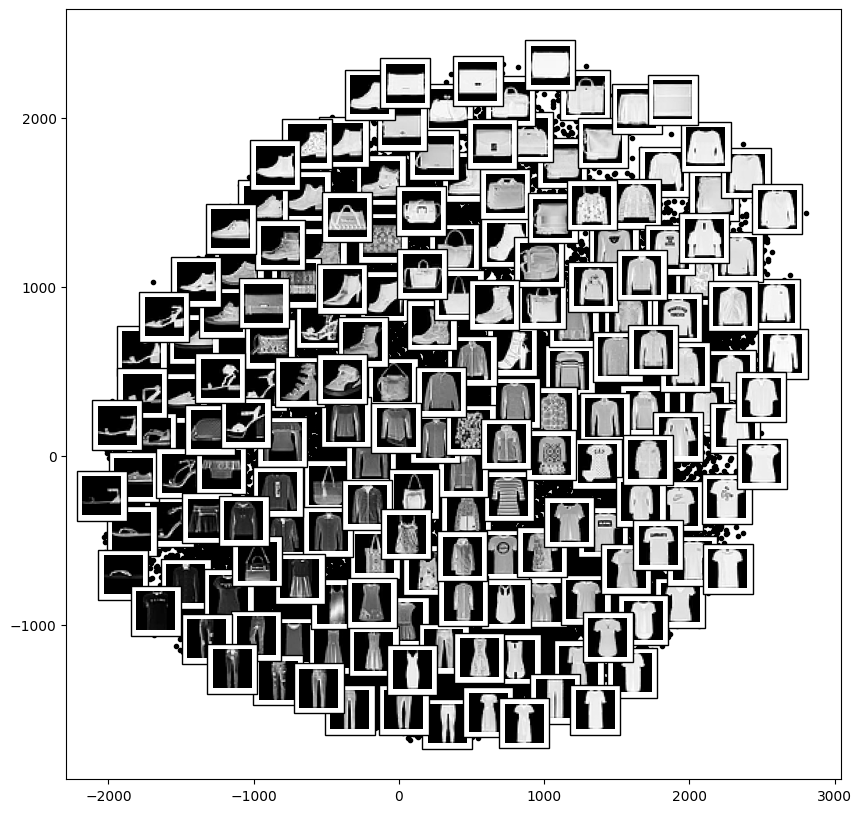

In [13]:
# use plot_components to show the data points
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data, ipca, images, ax=ax, thumb_frac=0.05)
plt.show()


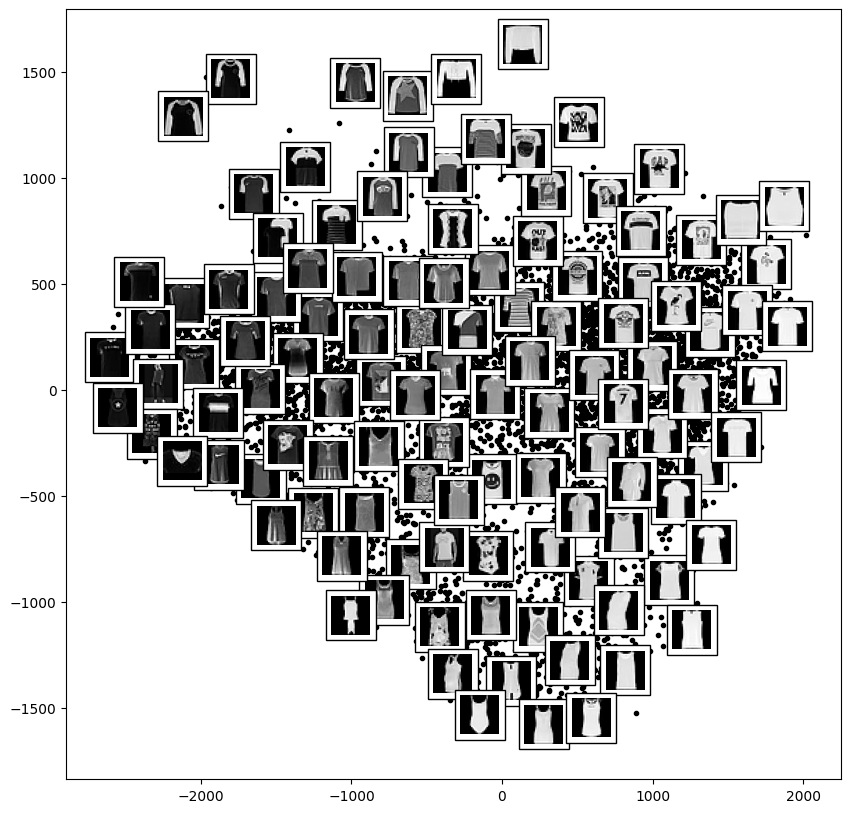

In [14]:
# show the data points with class label=0
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data[target==0], ipca, images[target==0], ax=ax, thumb_frac=0.05)
plt.show()


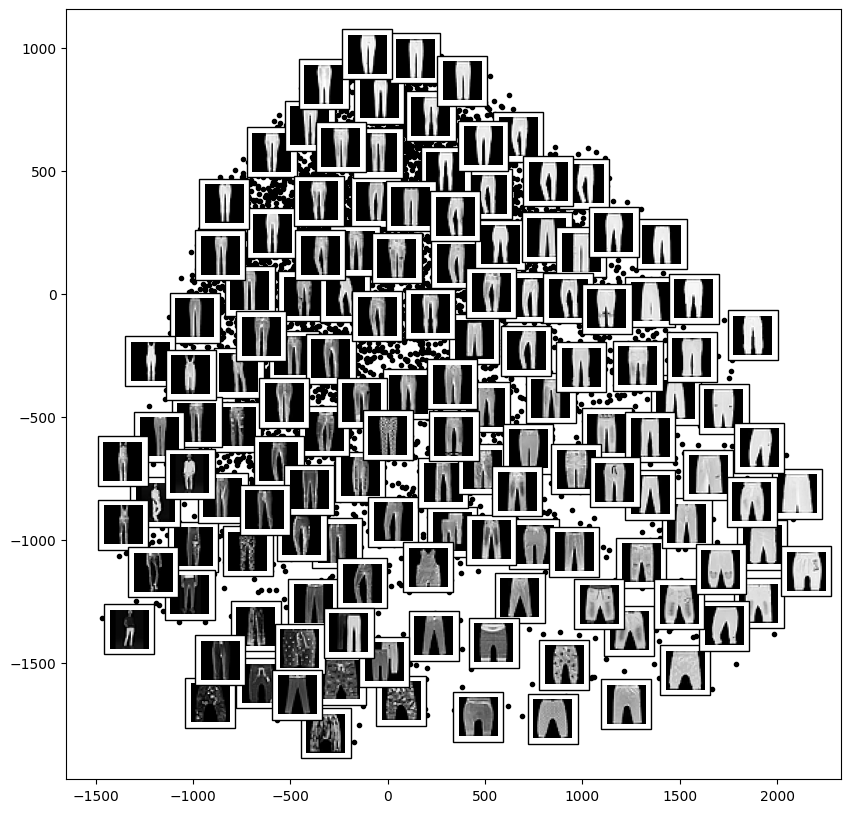

In [15]:
# show the data points with class label=1
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data[target==1], ipca, images[target==1], ax=ax, thumb_frac=0.05)
plt.show()


From the above examples, we can see that PCA can extract meaningful features from the images 

## Image Generation with PCA
 
We'll now explore how PCA can be used to generate new images:
1. Determine optimal number of components
2. Analyze variance explained
3. Generate new images using PCA components

### Finding Optimal `n_components`

First, we need to figure out how many components we need

In [16]:
n_components = 100
ipca = IncrementalPCA(n_components=n_components, batch_size=100)
transformed_data = ipca.fit_transform(data)


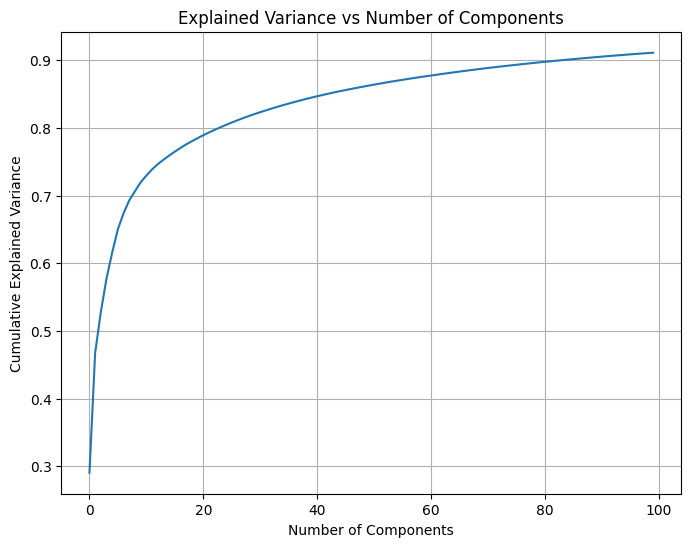

In [17]:
explained_variance = np.cumsum(ipca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

In [18]:
# find the smallest value of n_components such that the cumulative explained variance is >= 0.8
n_components = 0
cumulative_explained_variance = 0
while cumulative_explained_variance < 0.8:
    n_components += 1
    cumulative_explained_variance = explained_variance[n_components]

n_components


23

### Analyzing PCA Components
 
Let's examine the key elements of our PCA transformation:
- Mean image (average of all images)
- Eigenvalues (importance of each component)
- Eigenvectors (the actual components/directions)

In [19]:
# get the mean, eigenvalues, and eigenvectors from the pca model
mu = ipca.mean_
v = ipca.explained_variance_
w = ipca.components_

print("Mean shape: ", mu.shape, "Eigenvalues shape: ", v.shape, "Eigenvectors shape: ", w.shape)


Mean shape:  (784,) Eigenvalues shape:  (100,) Eigenvectors shape:  (100, 784)


### More Visualizations

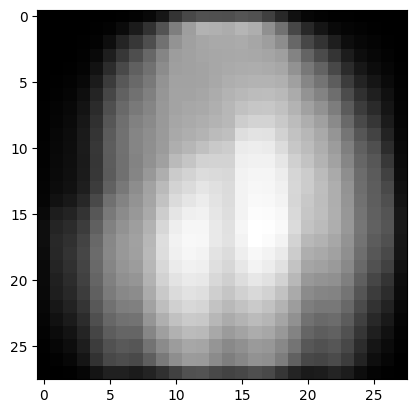

In [20]:
# plot the mean image from pca
plt.imshow(mu.reshape(28,28), cmap='gray')

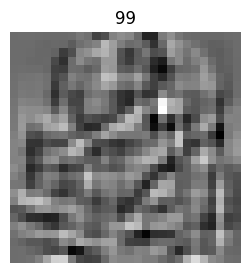

<Figure size 640x480 with 0 Axes>

In [21]:
# plot the first 100 eigenvectors
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 100):
    ax.imshow(w[n].reshape(28,28), cmap='gray')    
    ax.axis('off')
    ax.set_title(n)
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.2)


In [22]:
# L2 norm of an eigenvector w[0]
np.sum(w[0]**2)

1.0000000000000013

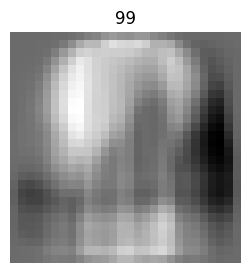

<Figure size 640x480 with 0 Axes>

In [23]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 100):
    y = 3*np.random.randn(n_components)
    x_new = mu + np.sum([y[k]*np.sqrt(v[k])*w[k] for k in range(n_components)], axis=0)
    ax.imshow(x_new.reshape(28,28), cmap='gray')    
    ax.axis('off')
    ax.set_title(n)
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.2)


PCA does not seem to be good at generating images. 


## Comparing with t-SNE Visualization

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a powerful dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data. Unlike PCA, which is a linear technique that focuses on preserving global structure, t-SNE is a non-linear technique that excels at preserving local structure.
 
### Key Characteristics of t-SNE:
 
1. **Local Structure Preservation**
    - Focuses on keeping similar points close together
    - Better at revealing clusters and patterns
    - May distort global structure to preserve local relationships
 
2. **Non-linear Dimensionality Reduction**
    - Can capture complex, non-linear relationships
    - More flexible than linear methods like PCA
    - Better for complex, real-world data
 
3. **Probabilistic Approach**
    - Converts high-dimensional distances to probabilities
    - Uses Student t-distribution in low-dimensional space
    - Minimizes KL divergence between probability distributions
 
### Limitations and Considerations:
 
1. **Computational Complexity**
    - O(n²) complexity with naive implementation
    - Much slower than PCA
    - Not suitable for very large datasets without modifications
 
2. **Non-deterministic**
    - Results can vary between runs
    - Requires random_state for reproducibility
    - May need multiple runs to ensure stable results
 
 3. **Parameter Sensitivity**
    - Perplexity parameter affects visualization
    - Learning rate needs careful tuning
    - Number of iterations affects convergence
 
 ### Why We're Using Both PCA and t-SNE:
 
 - PCA: Provides a fast, linear projection that preserves global structure
 - t-SNE: Offers a more detailed view of local patterns and clusters
 - Together: Give complementary views of the data structure
 
### Implementation Note:
 Due to t-SNE's computational complexity, we'll use a subset of our data:
 - Take every 100th sample
 - Maintains distribution while reducing computation time
 - Still provides meaningful visualization

In [24]:
#select a subset of data points for TSNE
#because TSNE is very time-consuming
data_s=data[0::100]
target_s=target[0::100]
images_s=images[0::100]

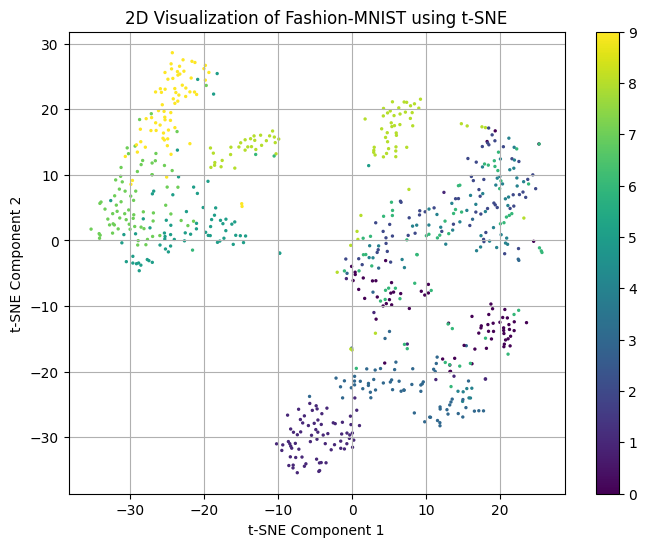

In [25]:
tsne = TSNE(n_components=2, random_state=0)
transformed_data_s = tsne.fit_transform(data_s)

plt.figure(figsize=(8, 6))
plt.scatter(transformed_data_s[:, 0], transformed_data_s[:, 1], c=target_s, cmap='viridis', s=2)
plt.colorbar()
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D Visualization of Fashion-MNIST using t-SNE')
plt.grid(True)
